In [62]:
!wget http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
!tar -xvzf WISDM_ar_latest.tar.gz
!rm -rf WISDM_ar_latest.tar.gz

--2018-12-16 12:31:45--  http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
Resolving www.cis.fordham.edu (www.cis.fordham.edu)... 150.108.68.29
Connecting to www.cis.fordham.edu (www.cis.fordham.edu)|150.108.68.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11404612 (11M) [application/x-gzip]
Saving to: ‘WISDM_ar_latest.tar.gz’

WISDM_ar_latest.tar 100%[===================>]  10.88M  13.8MB/s    in 0.8s    

2018-12-16 12:31:45 (13.8 MB/s) - ‘WISDM_ar_latest.tar.gz’ saved [11404612/11404612]

WISDM_ar_v1.1/
WISDM_ar_v1.1/readme.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1/WISDM_ar_v1.1_trans_about.txt


In [0]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import keras
from keras import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM, TimeDistributed, Activation, Dense
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
import re

%matplotlib inline

rcParams['figure.figsize'] = 14, 8

In [64]:
RANDOM_SEED = 42
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
if re.search(';', df.iloc[0, 5]) != None :
    df['z-axis'] = df['z-axis'].map(lambda x : float(re.sub(';', '', str(x))))
df = df.dropna()
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [65]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    labels.append(label)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


## LSTM Timeseries 전처리

In [0]:
data_gen = TimeseriesGenerator(np.array(df[['x-axis', 'y-axis', 'z-axis']]), np.repeat(0, len(df)),
                               length=200, sampling_rate=1, 
                               stride = 20, batch_size = len(labels))

In [0]:
x_all = data_gen[0][0]

In [68]:
x_all[0].shape

(200, 3)

In [0]:
y_all = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [70]:
pd.DataFrame(labels).groupby(0).size()

0
Downstairs     5031
Jogging       17102
Sitting        2994
Standing       2418
Upstairs       6133
Walking       21223
dtype: int64

In [71]:
temp_idx = 5000
print(labels[temp_idx])
y_all[temp_idx]

Downstairs


array([1., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
# train, test 로 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.3, random_state=42)

In [0]:
assert X_train.shape[0] == len(y_train)

In [74]:
y_train[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

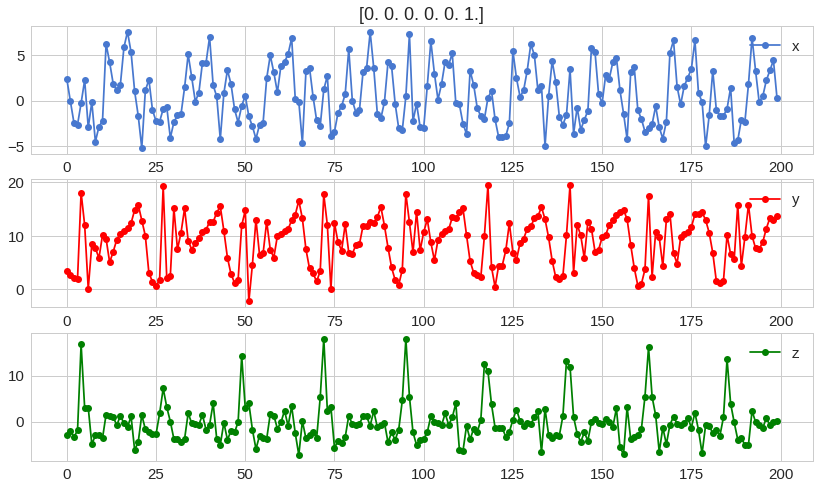

In [75]:
idx = 0

plt.figure(1)
plt.subplot(311)
plt.plot(X_train[idx, :, 0], 'o-')
plt.legend('x', loc = 'upper right')
plt.title(y_train[idx])

plt.subplot(312)
plt.plot(X_train[idx, :, 1], 'or-')
plt.legend('y', loc = 'upper right')

plt.subplot(313)
plt.plot(X_train[idx, :, 2], 'og-')
plt.legend('z', loc = 'upper right')

plt.show()

### 1. LSTM만으로 예측

In [0]:
hidden_size = 50
output_dim = len(np.unique(labels))

In [0]:
model = Sequential()
model.add(LSTM(hidden_size, input_shape = (N_TIME_STEPS, N_FEATURES)))
# model.add(LSTM(hidden_size, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(TimeDistributed(Dense(output_dim)))
model.add(Dense(output_dim))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, batch_size = 1024)

Train on 38430 samples, validate on 16471 samples
Epoch 1/10
38430/38430 [==============================] - 25s 641us/step - loss: 0.2490 - acc: 0.9141 - val_loss: 0.2525 - val_acc: 0.9117
Epoch 2/10
38430/38430 [==============================] - 25s 651us/step - loss: 0.2334 - acc: 0.9195 - val_loss: 0.2253 - val_acc: 0.9256
Epoch 3/10
38430/38430 [==============================] - 24s 634us/step - loss: 0.2114 - acc: 0.9269 - val_loss: 0.2107 - val_acc: 0.9285
Epoch 4/10
38430/38430 [==============================] - 24s 631us/step - loss: 0.2035 - acc: 0.9314 - val_loss: 0.2033 - val_acc: 0.9342
Epoch 5/10
38430/38430 [==============================] - 24s 626us/step - loss: 0.1931 - acc: 0.9337 - val_loss: 0.2083 - val_acc: 0.9326
Epoch 6/10
38430/38430 [==============================] - 24s 626us/step - loss: 0.1945 - acc: 0.9344 - val_loss: 0.1932 - val_acc: 0.9346
Epoch 7/10
38430/38430 [==============================] - 24s 628us/step - loss: 0.1877 - acc: 0.9358 - val_loss: 0.

In [89]:
hist.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

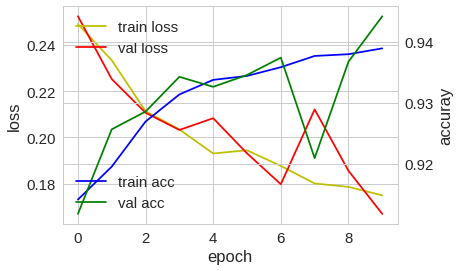

In [90]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### 2. DNN

In [0]:
# train, test 로 데이터 나누기
y_DNNall = np.asarray(pd.get_dummies(df['activity']), dtype = np.float32)
X_DNNtrain, X_DNNtest, y_DNNtrain, y_DNNtest = train_test_split(df[['x-axis', 'y-axis', 'z-axis']], y_DNNall, test_size=0.3, random_state=42)

In [0]:
hidden_size = 50
output_dim = len(np.unique(df['activity']))

In [0]:
model = Sequential()
model.add(Dense(hidden_size, activation = 'relu', input_dim = N_FEATURES))
model.add(Dense(int(hidden_size/2), activation = 'relu'))
model.add(Dense(int(hidden_size/4), activation = 'relu'))
model.add(Dense(output_dim))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [102]:
hist = model.fit(X_DNNtrain, y_DNNtrain, validation_data=(X_DNNtest, y_DNNtest), epochs = 10, batch_size = 256)

Train on 768742 samples, validate on 329461 samples
Epoch 1/10
768742/768742 [==============================] - 24s 31us/step - loss: 0.9718 - acc: 0.6271 - val_loss: 0.9663 - val_acc: 0.6285
Epoch 2/10
768742/768742 [==============================] - 24s 32us/step - loss: 0.9678 - acc: 0.6287 - val_loss: 0.9652 - val_acc: 0.6291
Epoch 3/10
768742/768742 [==============================] - 24s 32us/step - loss: 0.9666 - acc: 0.6286 - val_loss: 0.9632 - val_acc: 0.6316
Epoch 4/10
768742/768742 [==============================] - 24s 32us/step - loss: 0.9647 - acc: 0.6294 - val_loss: 0.9626 - val_acc: 0.6310
Epoch 5/10
768742/768742 [==============================] - 24s 31us/step - loss: 0.9638 - acc: 0.6296 - val_loss: 0.9593 - val_acc: 0.6314
Epoch 6/10
768742/768742 [==============================] - 24s 31us/step - loss: 0.9630 - acc: 0.6298 - val_loss: 0.9655 - val_acc: 0.6276
Epoch 7/10
768742/768742 [==============================] - 24s 32us/step - loss: 0.9624 - acc: 0.6300 - val

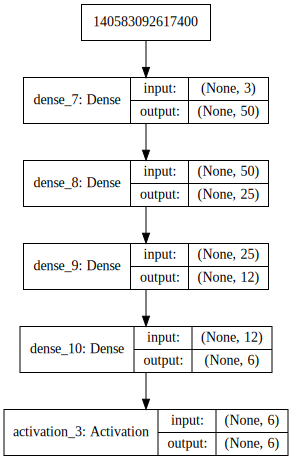

In [103]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 3. stacked LSTM + Autoencoder

In [0]:
hidden_size = 50
output_dim = len(np.unique(labels))

In [0]:
model = Sequential()
model.add(LSTM(hidden_size, return_sequences=True, input_shape = (N_TIME_STEPS, N_FEATURES)))
model.add(LSTM(hidden_size))
# model.add(Dropout(0.5))
# model.add(TimeDistributed(Dense(output_dim)))
model.add(Dense(output_dim))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [107]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, batch_size = 1024)

Train on 38430 samples, validate on 16471 samples
Epoch 1/10
38430/38430 [==============================] - 51s 1ms/step - loss: 1.1808 - acc: 0.6126 - val_loss: 0.8334 - val_acc: 0.7238
Epoch 2/10
38430/38430 [==============================] - 50s 1ms/step - loss: 0.7266 - acc: 0.7494 - val_loss: 0.6053 - val_acc: 0.7859
Epoch 3/10
38430/38430 [==============================] - 50s 1ms/step - loss: 0.5974 - acc: 0.7911 - val_loss: 0.7153 - val_acc: 0.7428
Epoch 4/10
38430/38430 [==============================] - 50s 1ms/step - loss: 0.8128 - acc: 0.7116 - val_loss: 0.6686 - val_acc: 0.7584
Epoch 5/10
38430/38430 [==============================] - 50s 1ms/step - loss: 0.6203 - acc: 0.7872 - val_loss: 0.5679 - val_acc: 0.8067
Epoch 6/10
38430/38430 [==============================] - 50s 1ms/step - loss: 0.5596 - acc: 0.8091 - val_loss: 0.5488 - val_acc: 0.8077
Epoch 7/10
38430/38430 [==============================] - 50s 1ms/step - loss: 0.5311 - acc: 0.8144 - val_loss: 0.4946 - val_acc

In [0]:
model = Sequential()
model.add(LSTM(hidden_size, return_sequences=True, input_shape = (N_TIME_STEPS, N_FEATURES)))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size))
# model.add(Dropout(0.5))
# model.add(TimeDistributed(Dense(output_dim)))
model.add(Dense(output_dim))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [116]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, batch_size = 1024)

Train on 38430 samples, validate on 16471 samples
Epoch 1/10
38430/38430 [==============================] - 78s 2ms/step - loss: 1.1819 - acc: 0.5963 - val_loss: 0.7866 - val_acc: 0.7416
Epoch 2/10
38430/38430 [==============================] - 75s 2ms/step - loss: 0.7156 - acc: 0.7513 - val_loss: 0.6559 - val_acc: 0.7765
Epoch 3/10
38430/38430 [==============================] - 74s 2ms/step - loss: 0.5884 - acc: 0.7875 - val_loss: 0.5191 - val_acc: 0.8146
Epoch 4/10
38430/38430 [==============================] - 74s 2ms/step - loss: 0.4860 - acc: 0.8226 - val_loss: 0.4224 - val_acc: 0.8506
Epoch 5/10
38430/38430 [==============================] - 77s 2ms/step - loss: 0.4741 - acc: 0.8207 - val_loss: 0.4595 - val_acc: 0.8318
Epoch 6/10
38430/38430 [==============================] - 77s 2ms/step - loss: 0.4018 - acc: 0.8503 - val_loss: 0.3393 - val_acc: 0.8736
Epoch 7/10
38430/38430 [==============================] - 78s 2ms/step - loss: 0.3370 - acc: 0.8730 - val_loss: 0.3011 - val_acc